⚠️ County 'karene' not found in shapefile!
⚠️ County 'karene' not found in shapefile!


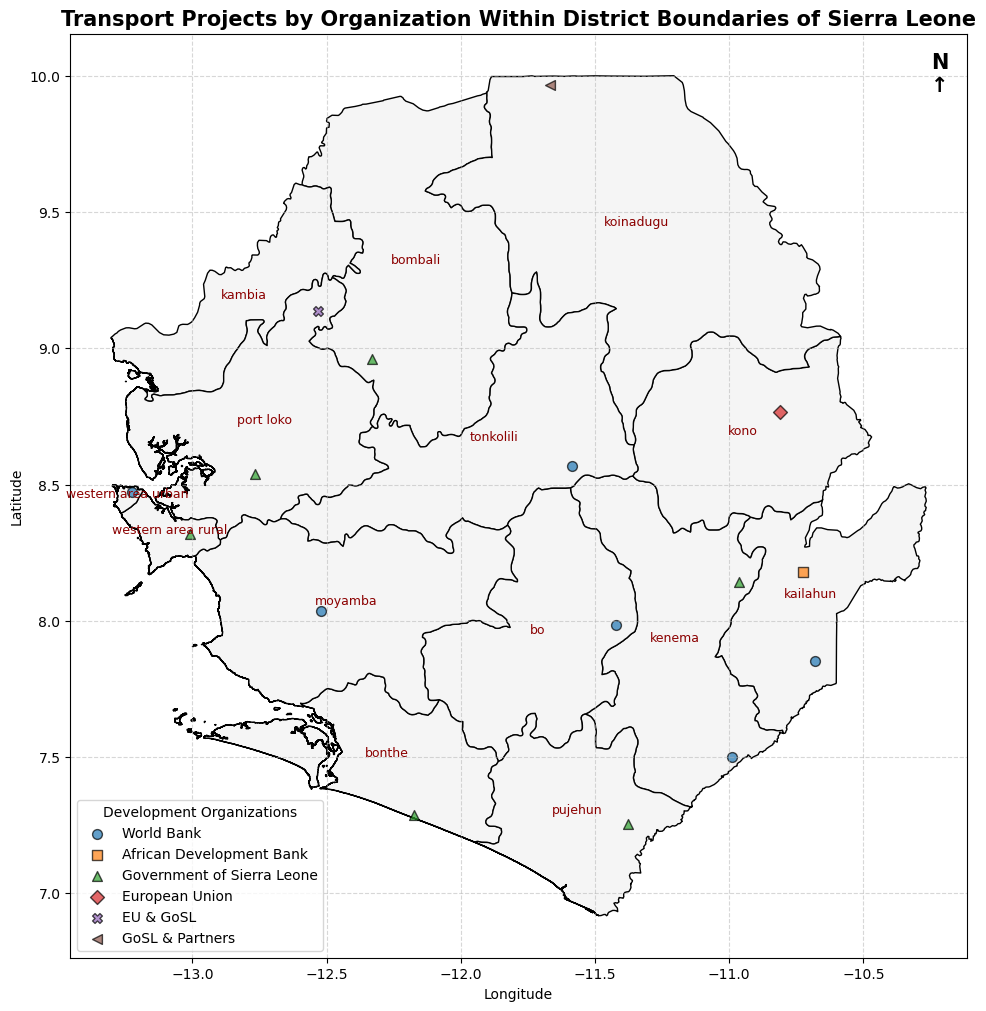

In [3]:
!pip install geopandas matplotlib pandas shapely
!pip install geodatasets
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Point
import numpy as np
from matplotlib.offsetbox import AnchoredText

# Step 1: Load Liberia county boundaries
Sierra_Leone = gpd.read_file("C:/Users/EliteBook/Desktop/HDS/gadm41_SLE.gpkg", layer="ADM_ADM_2").to_crs("EPSG:4326")

# Normalize county names to prevent mismatches
Sierra_Leone['NAME_2'] = Sierra_Leone['NAME_2'].str.strip().str.lower()

# Step 2: Load project dataset
project_data = pd.read_csv("Project_Counts_by_District_and_Funding_Agency.csv")
projects_df = pd.DataFrame(project_data)
projects_df["County"] = projects_df["County"].str.strip().str.lower()  # Ensure case consistency

# Step 3: Generate points within each county polygon
def generate_points_within(poly, num_points):
    """Generates points randomly within a given polygon (county)."""
    min_x, min_y, max_x, max_y = poly.bounds
    points = []
    while len(points) < num_points:
        random_point = Point(np.random.uniform(min_x, max_x), np.random.uniform(min_y, max_y))
        if poly.contains(random_point):
            points.append(random_point)
    return points

# Step 4: Generate project points
project_points = []
for _, row in projects_df.iterrows():
    county_name = row["County"]
    num_projects = row["Project Count"]
    organization = row["Funded by"]

    matching_rows = Sierra_Leone[Sierra_Leone['NAME_2'] == county_name]
    if len(matching_rows) == 0:
        print(f"⚠️ County '{county_name}' not found in shapefile!")
        continue

    county_polygon = matching_rows.geometry.values[0]

    # Shrink polygon slightly to move points away from boundaries
    county_polygon_inner = county_polygon.buffer(-0.01)  # Adjust the buffer as needed

    # Check for geometry validity
    if county_polygon_inner.is_empty or not county_polygon_inner.is_valid:
        county_polygon_inner = county_polygon

    points_in_county = generate_points_within(county_polygon_inner, num_projects)

    for point in points_in_county:
        project_points.append({"County": county_name, "Funded by": organization, "geometry": point})

# Convert to GeoDataFrame
projects_gdf = gpd.GeoDataFrame(project_points, crs="EPSG:4326")

# Step 5: Assign marker shapes for each organization
org_markers = {
    "World Bank": "o",  # Circle
    "African Development Bank": "s",  # Square
    "Government of Sierra Leone": "^",  # Triangle
    "European Union": "D",  # Diamond
    "Arab/World Bank": "P",  # Pentagon
    "EU & GoSL": "X",  # X shape
    "Islamic Dev. Bank(IsDB)": "h",  # Hexagon
    "IsDB & GoSL": "*",  # Star
    "GoSL & Partners": "<",  # Left triangle
    "GoSL/Pavi Fort": ">",  # Right triangle
    "Norway": "v",  # Downward triangle
    "Sweden": "d",  # Thin diamond
    "OFID": "H",  # Six-sided hexagon
    "SAUDI FUND FOR DEVELOPMENT": "p",  # Five-sided pentagon
}

# Step 6: Visualization
fig, ax = plt.subplots(figsize=(12, 12))
Sierra_Leone.plot(ax=ax, color='whitesmoke', edgecolor='black')

# Plot projects with different shapes based on funding organization
for org, marker in org_markers.items():
    subset = projects_gdf[projects_gdf["Funded by"] == org]
    
    if not subset.empty:  # Only plot if data exists for this organization
        subset.plot(ax=ax, markersize=50, marker=marker, alpha=0.7, edgecolor='k', label=org)

# Annotate county names at centroid
for idx, row in Sierra_Leone.iterrows():
    centroid = row['geometry'].centroid
    ax.annotate(row['NAME_2'], (centroid.x, centroid.y),
                fontsize=9, color='darkred', ha='center')

# Add North Arrow
north_arrow = AnchoredText("N\n↑", loc="upper right", prop={"size": 15, "weight": "bold"}, frameon=False)
ax.add_artist(north_arrow)

# Add legend
plt.legend(title="Development Organizations", fontsize=10, loc="lower left")

# Final plot adjustments
ax.set_title('Transport Projects by Organization Within District Boundaries of Sierra Leone',
             fontsize=15, fontweight='bold')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.grid(True, linestyle='--', alpha=0.5)

# 🔹 Save the plot as an image file
plt.savefig("Sierra_Leone_development_projects.png", dpi=300, bbox_inches="tight")  # Save as PNG
# plt.savefig("liberia_de7865432velopment_projects.pdf", dpi=300, bbox_inches="tight")  # Save as PDF
# plt.savefig("liberia_development_projects.svg", dpi=300, bbox_inches="tight")  # Save as SVG

plt.show()